# Trabalho 1

### Sobre o trabalho
- O trabalho tem os seguintes objetivos:
    - Preprocessar os dados de treino
    - Treinar um modelo Word2Vec com diferentes parâmetros
    - Avaliar o modelo treinado usando a tarefa de analogia semântica
### Ferramentas, dados e bibliotecas utilizadas
- O corpus de treino utilizado foi o corpus recomendado na descrição do trabalho
- O corpus de avaliação utilizado foi o corpus recomendado na descrição do trabalho
- A principal biblioteca utilizada para manipular os dados foi apenas a biblioteca recomendada: `Gensim`

In [20]:
import os

from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim import utils
import numpy as np
import matplotlib.pyplot as plt

## Choices for training and evaluating the model
- Context size (window size)
    - `window` arg: it's the number of words before and after the target word that the model will consider as context. The default value is 5.
- Training size
    - `epochs` arg: it's the number of times the model will see the whole corpus. The default value is 5.
- CBOW vs Skip-Gram
    - `sg` arg: 0 for CBOW, 1 for Skip-Gram. The default value is 0.
- Embedding size
    - `vector_size` arg: it's the size of the embedding vector. The default value is 100.

## Load corpus

- O preprocessamento adotado foi apenas:
    - Conversão para letras minúsculas
    - Remoção opcional de linhas que continham o caractere `:`

In [21]:
corpus = "text8"
corpus_path = os.path.join(os.getcwd(), corpus)

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, corpus, skip_lines: None | list=None):
        self.corpus = corpus
        self.skip_lines = skip_lines

    def __iter__(self):
        corpus_path = datapath(self.corpus)
        for line in open(corpus_path):
            # Skip lines
            if self.skip_lines is not None and line.startswith(self.skip_lines):
                continue
            # assume there's one document per line, tokens separated by whitespace
            preprocessed_line = self._preprocess_text(line)
            yield utils.simple_preprocess(preprocessed_line)

    def _preprocess_text(self, text):
        """Lowercase all text"""
        text = text.lower()
        return text

    def __len__(self):
        return sum(1 for _ in self)

train_sentences = MyCorpus(corpus_path)

## Define train and vocabulary functions

In [22]:
def train_word2vec(sentences, **args):
    model = Word2Vec(sentences=sentences, **args)
    return model

def get_vocabulary(model):
    vocabulary = model.wv.key_to_index
    # print(f"vocabulary size: {len(vocabulary)}")
    return vocabulary

## Evaluation

#### Load evaluation corpus
- Pula linhas que que tem `:` no texto

In [23]:
evaluation_corpus_path = os.path.join(os.getcwd(), "questions-words.txt")
evaluation_sentences = MyCorpus(evaluation_corpus_path, skip_lines=":")

print(f"Evaluation corpus size: {evaluation_sentences.__len__()}")

Evaluation corpus size: 19544


# Define evaluation functions
### Downstream application: Semantic Analogy task
##### Obs: 8.79% do corpus de avaliação não está¹ no vocabulário, então não é utilizado na avaliação do modelo
¹: pelo menos uma das quatro palavras avaliadas não está no vocabulário

In [24]:
def are_words_in_vocabulary(words, vocabulary):
    """Check if all words are in the vocabulary\\
    Arguments:
        words (list): list of words to check
        vocabulary (dict): vocabulary
    Returns:
        bool: True if all words are in the vocabulary, False otherwise
    """
    return all(word in vocabulary for word in words)


def create_and_plot_histogram(data, bins=100):
    """Create and plot a histogram\\
    Arguments:
        data (list): data to plot
        bins (int): number of bins
    """
    _, bins = np.histogram(data, bins=bins)
    plt.hist(data, bins=bins)
    plt.xlabel("Cosine similarity")
    plt.ylabel("Frequency")
    plt.title("Cosine similarity distribution")
    plt.show()


def evaluate_word_analogies(model, vocabulary, evaluation_sentences,
                            print_good_analogies):
    """Evaluate according to: `most similar  = (vector of first word)`
    `- (vector of second word) + (vector of third word)`. Show a
    plot with the cosine similarity distribution on the evaluation
    corpus. If `print_good_analogies` is True, print the most similar
    word up to 5 times. Even if it is True, it will only print
    randomly to avoid always printing the same words.\\
    Arguments:
        model (Word2Vec): trained word2vec model
        vocabulary (dict): vocabulary
        evaluation_sentences (MyCorpus): evaluation corpus
        print_good_analogies (bool): print good analogies. Default: `False`
    """
    total_distance = []
    skipped_words, words_printed = 0, 0
    MAX_PRINT_WORDS = 5
    MIN_SIMILARITY_TO_PRINT = 0.95
    random_coin = np.random.rand()

    for words in evaluation_sentences:
        # skip if any of the words are not on the vocabulary
        if not are_words_in_vocabulary(words, vocabulary):
            skipped_words += 1
            continue

        first_two_words = words[:2]
        third_word = words[2]
        last_word = words[3]
        # Get the most similar word using cosine similarity
        most_similar = model.wv.most_similar(positive=first_two_words,
                                            negative=third_word)[0][0]

        # Compute the cosine similarity between the most similar word and the correct word
        similarity = model.wv.similarity(most_similar, last_word)
        total_distance.append(similarity)

        if (print_good_analogies and similarity > MIN_SIMILARITY_TO_PRINT \
            and words_printed < MAX_PRINT_WORDS) and random_coin < 0.5:
            words_printed += 1
            print(f"Most similar word to {first_two_words} and {third_word} is " + 
                  f"{most_similar}. Last word is {last_word}")

    # lines_not_used = (skipped_words*100)/evaluation_sentences.__len__()
    # if lines_not_used > 0:
    #     print("Skipped some words that were not in the vocabulary")
    #     print(f"Skipped {skipped_words} words (lines), which is " +
    #         f"{lines_not_used:.2f}% of the evaluation corpus size")

    # Compute the average distance
    average_distance = np.mean(total_distance)
    std_distance = np.std(total_distance)
    minimum_distance = np.min(total_distance)
    maximum_distance = np.max(total_distance)

    print(f"Average distance: {average_distance:.6f},     STD distance: {std_distance:.6f}")
    print(f"Minimum distance: {minimum_distance:.6f}, Maximum distance: {maximum_distance:.6f}")

    # show frequency distribution of cosine similarity distances
    create_and_plot_histogram(total_distance)


def train_and_evaluate_model(print_good_analogies=False, **args):
    """Train and evaluate a word2vec model. If no arguments are passed,
    the default values are used."""
    model = train_word2vec(train_sentences, **args)
    vocabulary = get_vocabulary(model)
    evaluate_word_analogies(model, vocabulary, evaluation_sentences, print_good_analogies)

# Train and evaluate the model with different parameters

### Let's train using Word2Vec default values

Average distance: 0.000234,     STD distance: 0.108065
Minimum distance: -0.393861, Maximum distance: 0.838508


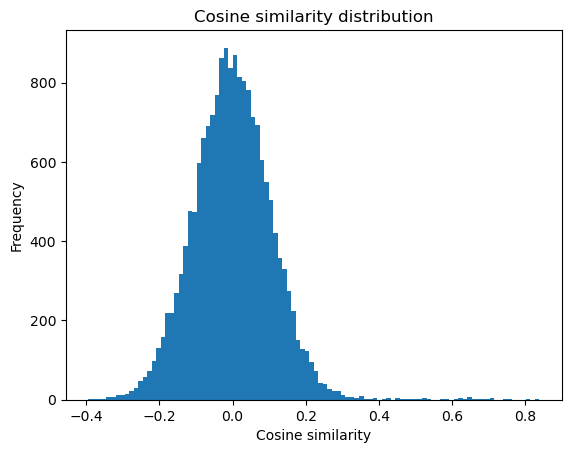

In [25]:
train_and_evaluate_model()

#### Let's train for more epochs

Average distance: -0.015005,     STD distance: 0.253605
Minimum distance: -0.927113, Maximum distance: 0.994625


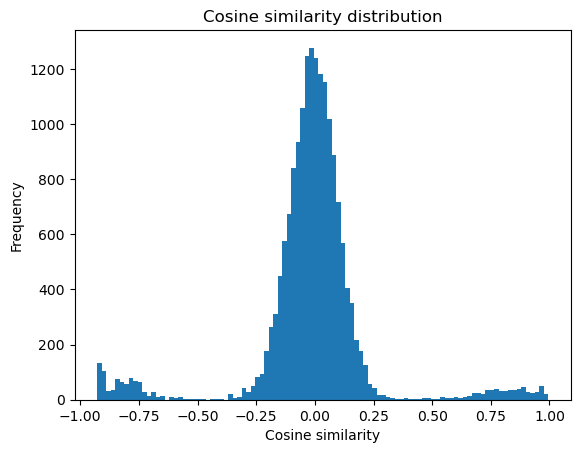

In [26]:
train_and_evaluate_model(print_good_analogies=True, epochs = 10)

#### Let's train for even more epochs

Average distance: -0.024305,     STD distance: 0.295460
Minimum distance: -0.982512, Maximum distance: 0.998316


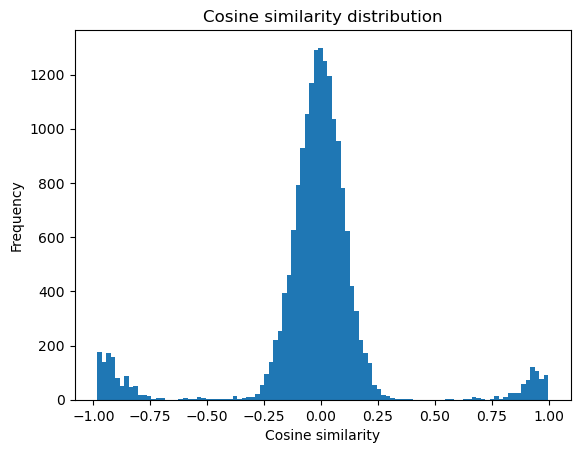

In [27]:
train_and_evaluate_model(print_good_analogies=True, epochs = 15)

### Let's see if using skip-gram instead of CBOW makes any difference

Most similar word to ['berlin', 'germany'] and madrid is strategy. Last word is spain
Most similar word to ['berlin', 'germany'] and moscow is subtle. Last word is russia
Most similar word to ['berlin', 'germany'] and paris is expect. Last word is france
Most similar word to ['london', 'england'] and madrid is tests. Last word is spain
Most similar word to ['paris', 'france'] and berlin is hakim. Last word is germany
Average distance: 0.023362,     STD distance: 0.221505
Minimum distance: -0.417589, Maximum distance: 0.996980


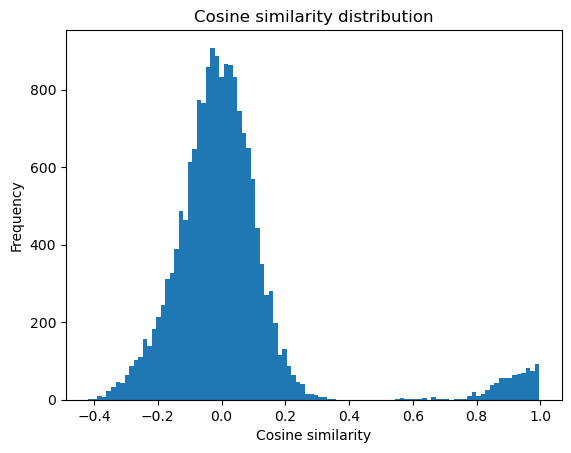

In [28]:
train_and_evaluate_model(print_good_analogies=True, sg = 1)

#### Let's add more training epochs

Most similar word to ['beijing', 'china'] and madrid is occurred. Last word is spain
Most similar word to ['beijing', 'china'] and moscow is wto. Last word is russia
Most similar word to ['beijing', 'china'] and ottawa is hypothesis. Last word is canada
Most similar word to ['berlin', 'germany'] and madrid is bitter. Last word is spain
Most similar word to ['berlin', 'germany'] and moscow is catalonia. Last word is russia
Average distance: 0.026960,     STD distance: 0.236135
Minimum distance: -0.406740, Maximum distance: 0.998973


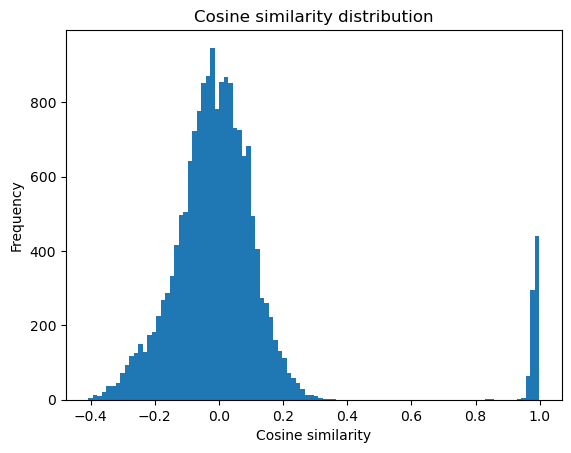

In [29]:
train_and_evaluate_model(print_good_analogies=True, epochs = 10, sg = 1)

### Now, let's see the effect of changing the vector size, i.e., the embedding size

Average distance: -0.002053,     STD distance: 0.147016
Minimum distance: -0.662665, Maximum distance: 0.859386


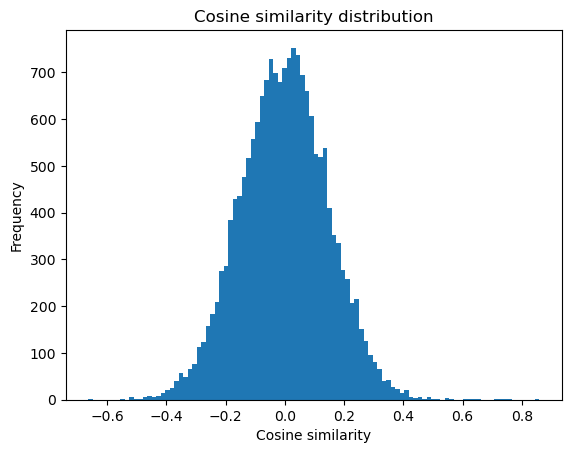

In [30]:
train_and_evaluate_model(vector_size = 50)

#### Reducing the vector size a little more

Most similar word to ['cambodia', 'cambodian'] and moldova is moldovan. Last word is moldovan
Average distance: 0.003239,     STD distance: 0.320650
Minimum distance: -0.916523, Maximum distance: 1.000000


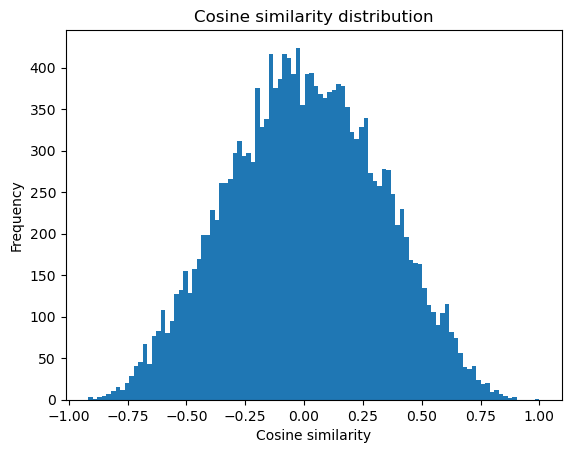

In [31]:
train_and_evaluate_model(print_good_analogies=True, vector_size = 10)

### Maintain a small vector size and reduce the context size

Average distance: 0.003664,     STD distance: 0.319754
Minimum distance: -0.898974, Maximum distance: 1.000000


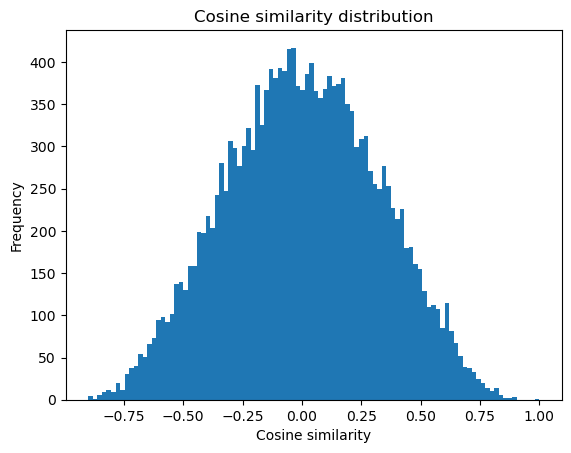

In [32]:
train_and_evaluate_model(print_good_analogies=True, vector_size = 10, window = 4)

#### Maintain a small vector size and reduce the context size even more

Most similar word to ['cambodia', 'cambodian'] and moldova is moldovan. Last word is moldovan
Average distance: 0.005584,     STD distance: 0.319211
Minimum distance: -0.931199, Maximum distance: 1.000000


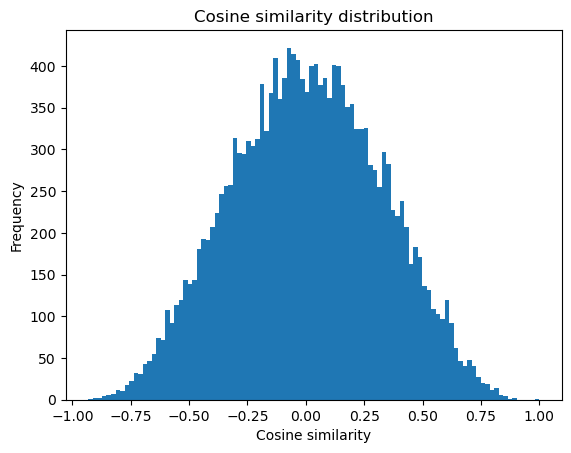

In [33]:
train_and_evaluate_model(print_good_analogies=True, vector_size = 10, window = 3)

### Now, let's see the effect of changing only the context size

Average distance: -0.000743,     STD distance: 0.100507
Minimum distance: -0.407694, Maximum distance: 0.494997


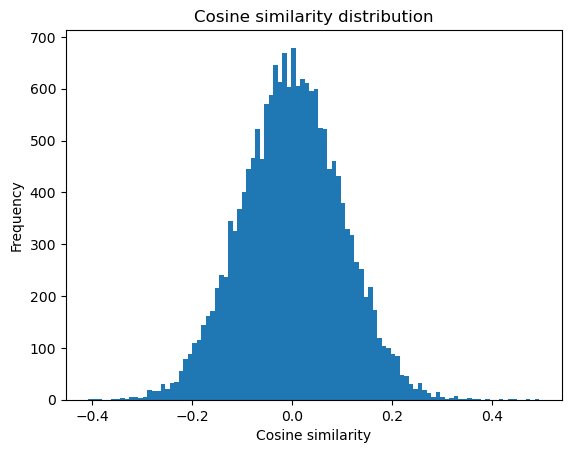

In [34]:
train_and_evaluate_model(print_good_analogies=True, window = 3)

#### Let's maintain a small context size and use Skip-Gram instead of CBOW

Average distance: 0.010290,     STD distance: 0.176386
Minimum distance: -0.538357, Maximum distance: 0.993621


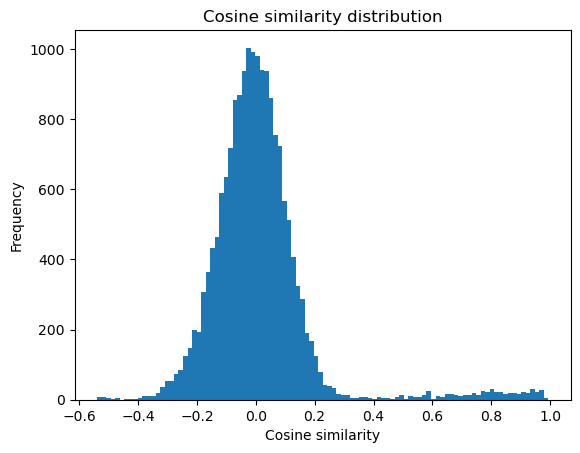

In [35]:
train_and_evaluate_model(print_good_analogies=True, sg=1, window = 3)

# Referências:
- [Slides da disciplina de NLP](https://homepages.dcc.ufmg.br/~adrianov/nlp/)
- [Gensim Tutorial: Word2Vec Model](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html)
- [Gensim API - Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)
- [Gensim API - KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors)
- [StatQuest with Josh Starmer - Similaridade de cosseno, claramente explicada!!! ](https://youtu.be/e9U0QAFbfLI?si=FR7oyq3EyIWHH04B)